# 2/19/20
***
Мне снова задали вопрос о коррелированном отборе, поэтому надо с ним разобраться

In [53]:
import numpy as np
import uproot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob

%matplotlib inline

sns.set(rc={'figure.figsize':(13,7)}, font_scale=1.7)
plt.style.use('seaborn-whitegrid')

Посмотрю картинки, на которых видно коррелированный отбор

In [251]:
ebeam = 550
mom_tree_exp = uproot.open(glob(f'../../outputs/19/trees/{ebeam}*.root')[0])['pic_mom']
mom_tree_mc = uproot.open(glob(f'../../outputs/model_old_v7/trees/{ebeam}*.root')[0])['pic_mom']

In [252]:
mom_df_exp = mom_tree_exp.pandas.df()
mom_df_mc = mom_tree_mc.pandas.df()

In [253]:
p_cut = 2 * (0.0869 * ebeam - 36.53)
p0 = np.sqrt(ebeam**2 - 497.6**2)

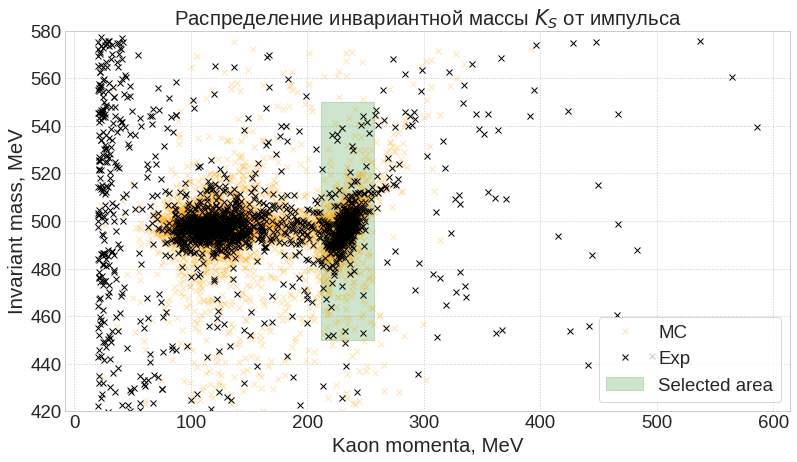

In [257]:
plt.plot(mom_df_mc.momentum, mom_df_mc.mass, 'x', label='MC', alpha=0.3, c='orange')
plt.plot(mom_df_exp.momentum, mom_df_exp.mass, 'x', label='Exp', c='black')
plt.fill_between([p0-p_cut, p0+p_cut], [450, 450], [550, 550], color='green', alpha=0.2, label='Selected area')
plt.grid(linestyle=":")
# plt.xlim(50, 350);
plt.ylim(420, 580);
plt.legend(frameon=True);
# plt.text(250, 560, "1.1 GeV, 2019");
plt.title('Распределение инвариантной массы $K_S$ от импульса')
plt.xlabel('Kaon momenta, MeV');
plt.ylabel('Invariant mass, MeV');

Проверяю гипотезу о том, что фон пикуется, для этого
1. Смотрю распределение по импульсу каона, беру сайд-бенды
2. Смотрю как события из сайд-бендов ведут себя на картинке и инвариантной массой

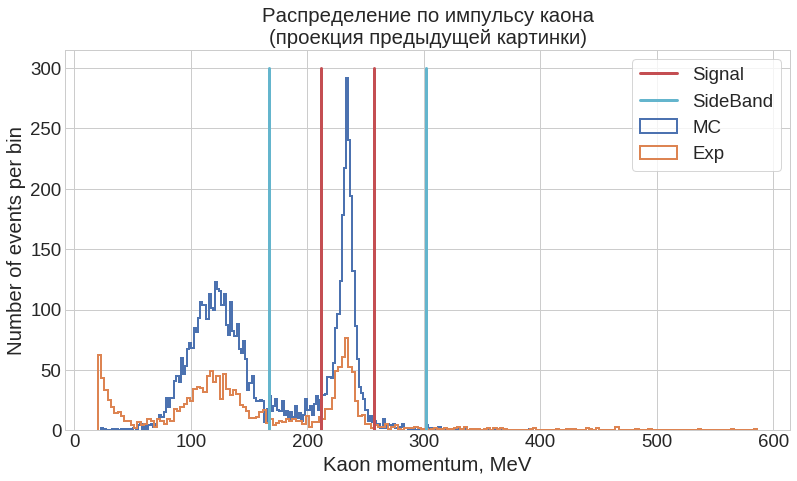

In [259]:
sideband = 3*p_cut
plt.hist(mom_df_mc.momentum, bins=200, histtype='step', lw=2, label='MC');
plt.hist(mom_df_exp.momentum, bins=200, histtype='step', lw=2, label='Exp');
plt.plot([p0-p_cut, p0-p_cut], [0, 300], c='r', lw=3)
plt.plot([p0+p_cut, p0+p_cut], [0, 300], c='r', lw=3, label='Signal')
plt.plot([p0-sideband, p0-sideband], [0, 300], c='c', lw=3)
plt.plot([p0+sideband, p0+sideband], [0, 300], c='c', lw=3, label='SideBand');
plt.legend(frameon=True)
plt.title('Распределение по импульсу каона\n(проекция предыдущей картинки)')
plt.ylabel('Number of events per bin');
plt.xlabel('Kaon momentum, MeV');
# plt.xlim(100, 500)

In [263]:
sideband_area = dict()
sideband_area['exp'] = mom_df_exp.query('abs(momentum-@p0)<@sideband&abs(momentum-@p0)>@p_cut')
sideband_area['mc'] = mom_df_mc.query('abs(momentum-@p0)<@sideband&abs(momentum-@p0)>@p_cut')

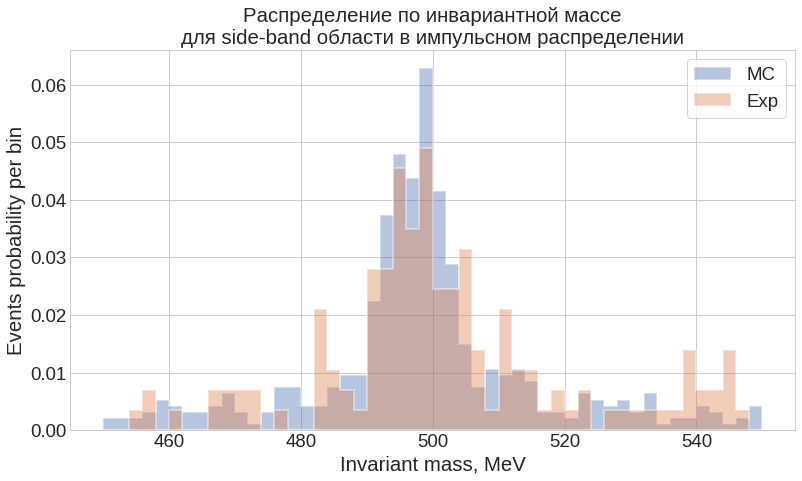

In [273]:
plt.hist( sideband_area['mc'].mass, 
         bins=50, histtype='stepfilled', lw=2, density=True, range=(450, 550), alpha=0.4, label='MC' );
plt.hist( sideband_area['exp'].mass, 
         bins=50, histtype='stepfilled', lw=2, density=True, range=(450, 550), alpha=0.4, label='Exp' );
plt.legend(frameon=True);
plt.title('Распределение по инвариантной массе\nдля side-band области в импульсном распределении')
plt.xlabel('Invariant mass, MeV');
plt.ylabel('Events probability per bin');

Видно, что в области массы $K_S$ наблюдается пик, однако этот пик также присутствует в моделировании, что говорит о том, что там находятся неотобранные мной $K_S$-мезоны, поэтому для реального определения фона нужно вычесть из эксперимента моделирование, для этого:
1. Определяю число событий в эксперименте по форме MC
1. Вычитаю это количество из MC

In [318]:
import iminuit
import probfit as pf

In [320]:
mass_bound = (450, 550)

def constant(x):
    return 1
def gauss(x, mu, sigma):
    return pf.gaussian(x, mu, sigma)

norm_sig = pf.rename( pf.Normalized( gauss, mass_bound ), ['x', 'M', '$\\sigma$'] )
norm_bkg = pf.Normalized( constant, mass_bound )

ext_sig = pf.Extended(norm_sig, extname='$N_{sig}$')
ext_bkg = pf.Extended(norm_bkg, extname='$N_{bkg}$')

pdf = pf.AddPdf(ext_sig, ext_bkg)

MLim = (497.6, 7.0)
sigmaLim = (6.60, 6.0)

limits = {
    "limit_M": [MLim[0]-MLim[1], MLim[0]+MLim[1]],
    "limit_$\\sigma$": [sigmaLim[0] - sigmaLim[1], sigmaLim[0] + sigmaLim[1]],
    "limit_$N_{sig}$": [0, 100000],
    "limit_$N_{bkg}$": [0, 2000],
}
errors = {
    "error_M": 1,
    "error_$\\sigma$": 0.1,
    "error_$N_{sig}$": 0.3,
    "error_$N_{bkg}$": 0.1,
}

pf.describe(pdf)

['x', 'M', '$\\sigma$', '$N_{sig}$', '$N_{bkg}$']

In [325]:
def fitter(dic, nbins):
    
    likelihood = pf.UnbinnedLH(pdf, dic, extended=True, extended_bound=mass_bound)
    
    initial_par_values = {"M": 497.6, "$\sigma$": 4.26, "$N_{sig}$": np.size(dic), "$N_{bkg}$": 1}
    mt = iminuit.Minuit(likelihood, **initial_par_values, **errors, **limits, pedantic=False)
    mt.migrad();
        
    likelihood.draw(minuit=mt, bins=nbins, bound=mass_bound)
    return mt, likelihood

Text(0.5, 1.0, 'Фит эксперимента')

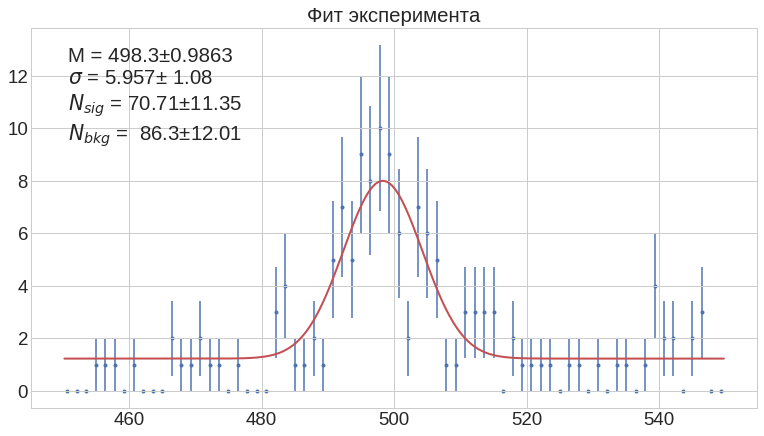

In [361]:
mt_exp, _ = fitter(sideband_area['exp'].mass.values, 70);
plt.title('Фит эксперимента');

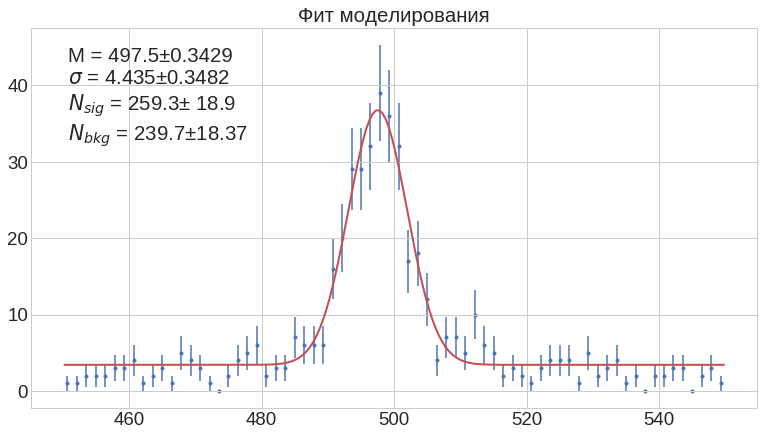

In [362]:
mt_mc, _ = fitter(sideband_area['mc'].mass.values, 70);
plt.title('Фит моделирования');

In [371]:
n_mc = 10000
mc_ = np.random.normal(mt_mc.values.values()[0], mt_mc.values.values()[1], n_mc)

In [376]:
mc, bin_edges = np.histogram( mc_, bins=50, range=(450, 550) );
mc_err = np.sqrt(mc);
exp, bin_edges = np.histogram( sideband_area['exp'].mass, bins=50, range=(450, 550) );
exp_err = np.sqrt(exp);

mc, mc_err = mc*mt_exp.values.values()[2]/n_mc, mc_err*mt_exp.values.values()[2]/n_mc
bin_centers = (bin_edges[1:] + bin_edges[:1])/2.

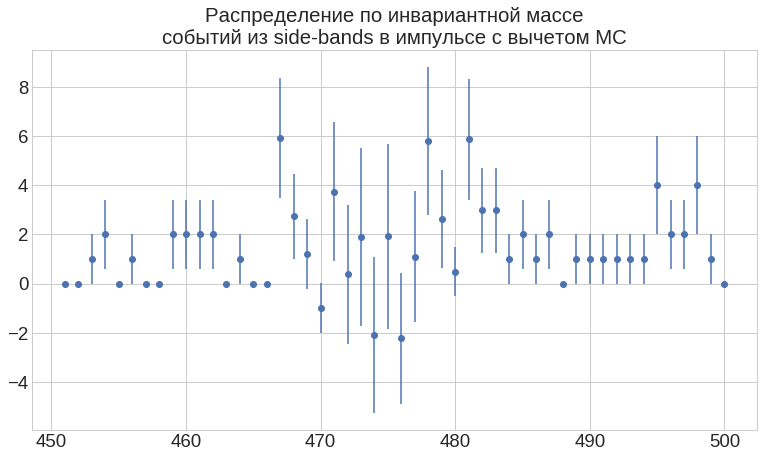

In [386]:
plt.errorbar( x=bin_centers, y=exp-mc, yerr=np.sqrt( exp_err**2 + mc_err**2 ), fmt='o' )
plt.title("Распределение по инвариантной массе\nсобытий из side-bands в импульсе с вычетом MC");

Если я всё сделал правильно, то полученная выше картинка говорит о том, что пика в фоне нет

*Ради интереса попробую повернуть оси*

In [378]:
cov_matrix = mom_df_mc.query('abs(momentum-@p0)<@p_cut')[['momentum','mass']].cov().values
cov_matrix

array([[ 61.63748149,  20.47420831],
       [ 20.47420831, 139.67546454]])

In [379]:
vP = ( cov_matrix[0,0] )
vM = ( cov_matrix[1,1] )
covMP = cov_matrix[0,1]

phi = (1/2)*np.arcsin( covMP/(vP - vM) )

Угол поворота найден, теперь нужно повернуть координаты

In [380]:
A = np.array([[0.5, 0], [0, 1]])
R = np.array([ [np.cos(phi), np.sin(phi)], [-np.sin(phi), np.cos(phi)] ] )

In [381]:
A = mom_df_mc[['momentum', 'mass']].values.T
B = mom_df_exp[['momentum', 'mass']].values.T

In [382]:
new_df_mc = pd.DataFrame( np.matmul(R, A).T )
new_df_exp = pd.DataFrame( np.matmul(R, B).T )

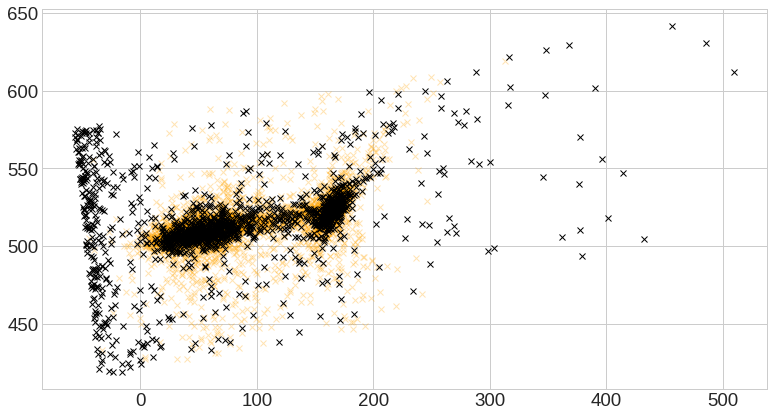

In [383]:
plt.plot(new_df_mc[0], new_df_mc[1], 'x', label='MC', alpha=0.3, c='orange')
plt.plot(new_df_exp[0], new_df_exp[1], 'x', label='Exp', c='black')